# Experimento voces pitcheadas

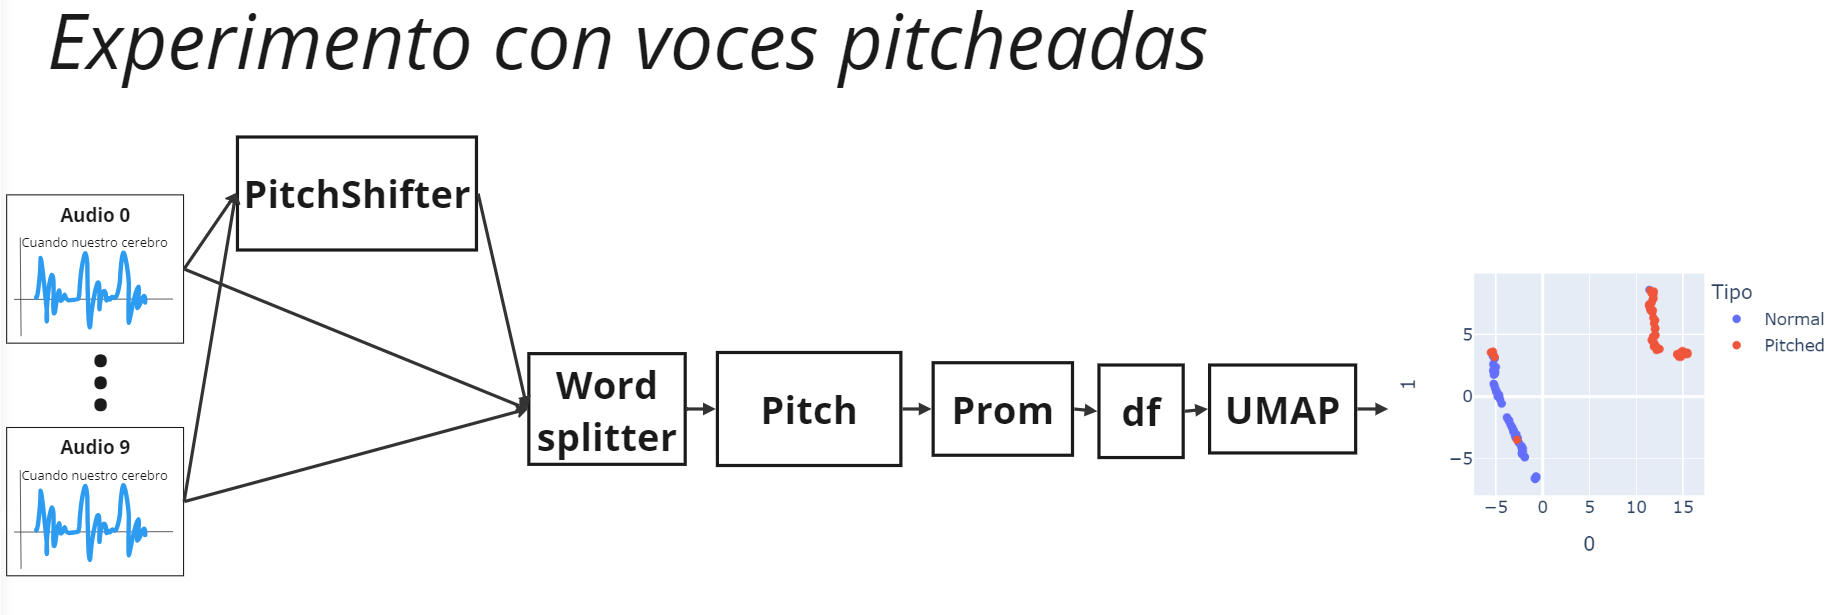

## Funciones

### Calculadora de pitch

In [9]:
import librosa
import math

def Pitch(y,sr):
    f0, voiced_flag, voiced_probs=librosa.pyin(
        y,
        fmin=librosa.note_to_hz('C2'),
        fmax=librosa.note_to_hz('C7'),
        sr=sr)
    f0 = [x for x in f0 if not isinstance(x, float) or not math.isnan(x)]
    f0 = [i for i in f0 if i != 0]
    return f0

### Promediador

In [10]:
import numpy as np

def Promediador(x):
    return np.mean(x)

### Calculadora de Loudness

In [11]:
import pyloudnorm as pyln

def Loudness(y,sr):
    meter = pyln.Meter(sr)
    loudness = meter.integrated_loudness(y)
    return loudness

### PitchShifter

In [19]:
import torch
import torchaudio
import soundfile as sf

def PitchShifter(input_file_path,output_name,semi_tonos):
    audio,sr = sf.read(input_file_path)
    audio = torch.tensor(audio)
    y= torchaudio.functional.pitch_shift(
        waveform = audio,
        sample_rate = sr,
        n_steps=semi_tonos)
    output_name = f'{output_name}.wav'
    sf.write(output_name, y,samplerate=sr)

# Ejemplo
# input_file_path = 'C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/ZP/E0_ZP.wav'
# output_name = 'NombreDePrueba'
# semi_tonos = 8
# PitchShifter(input_file_path,output_name,semi_tonos)

In [21]:
def PitchearTodasLasVoces(cant_audios,input_file_path_main,output_file_path_main,semi_tonos):
    for i in range(cant_audios):
        input_file_path = f'{input_file_path_main}/{file_names[i]}.wav'
        output_file_path = f'{output_file_path_main}/{file_names[i]}_pitcheado'
        PitchShifter(input_file_path,output_file_path,semi_tonos)

cant_audios = 29
file_names = [f'E{i}_ZP' for i in range(cant_audios)]
input_file_path_main = 'C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/ZP'
output_file_path_main = 'C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/ZP_pitcheados'
semi_tonos = 8
PitchearTodasLasVoces(cant_audios,input_file_path_main,output_file_path_main,semi_tonos)

## Función cargar los parámetros acústicos a un df

In [12]:
import pandas as pd

def CalcularYCargarParametrosAcusticosAldf(path_carpeta, nombre, cant_audios, extension, cant_basesdedatos):
    df = pd.DataFrame(columns=['Pitch', 'Loudness','Tipo'])
    for j in range(cant_basesdedatos):
        for i in range(cant_audios):
            path = f'{path_carpeta}/{nombre[j]}{i}.{extension[j]}'    
            y,sr = librosa.load(path)
            p=Promediador(Pitch(y,sr))
            l=Promediador(Loudness(y,sr))
            if j==0:
                variable_tipo = 'Normal' 
            elif j==1:
                variable_tipo = 'Pitched'
            df = df.append({'Pitch':p, 'Loudness':l,'Tipo':variable_tipo},ignore_index=True)
    return df

## AudioChunker

In [22]:
from pydub import AudioSegment
from pydub.silence import split_on_silence

def AudioChunker(file_name,raw_audio_path,chunk_storage_directory,min_silence_len,silence_thresh):
    """
    Toma un audio y lo separa por silencios en chunks a partir de los parámetros min_silence_len y silence_thresh
        Entradas:
            file_name (str): nombre del archivo de audio a ser seccionado en chunks (audio con el zero padding).
            raw_audio_path (str): path donde esta el archivo a ser seccionado.
            chunk_storage_directory (str): path donde se va a ubicar el archivo seccionado.
            min_silence_len (int): cualquier silencio que dure mas que este valor es recortado.
            silence_thresh (float): cualquier nivel que es menor que este umbral es considerado silencio.
    """
    sound_file = AudioSegment.from_wav(raw_audio_path)
    audio_chunks = split_on_silence(
        sound_file,
        min_silence_len,
        silence_thresh = sound_file.dBFS-silence_thresh
        )
    for i, chunk in enumerate(audio_chunks):
        out_file = f"{chunk_storage_directory}/chunk{i}_de_{file_name}.wav"
        print(f'Audio{i}', out_file)
        chunk.export(out_file, format="wav")

#Ejemplo
# file_name = 'E1'
# raw_audio_path = 'C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/E0_ZP.wav'
# chunk_storage_directory = 'C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/Chunks'
# min_silence_len = 1000
# silence_thresh = 15
# AudioChunker(file_name,raw_audio_path,chunk_storage_directory,min_silence_len,silence_thresh)

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## RecortarTodasLasPalabras

In [23]:
def RecortarTodasLasPalabras(cant_audios,raw_audio_path_main,chunk_storage_directory_main,chunk_name_folder,min_silence_len,silence_thresh):
    """
    Toma varios audios ubicados en una carpeta y a cada uno de los audios lo secciona por silencios en chunks y luego los ubica en distintas carpetas.
    Utiliza la funcion AudioChunker. Ejemplo: si los audios son E1_ZP,E2_ZP,...,E30_ZP 
    Arguments:
        cant_audios (int): cantidad de audios a ser segmentados
        raw_audio_path_main (str): path de la carpeta donde estan ubicados totos los audios a ser segmentados
        chunk_storage_directory_main (str): path de la carpeta donde van a ser ubicados los archivos
        chunk_name_folder (str): nombre de la subcarpeta donde se va a ubicar el i-esimo chunk. Ej: los chunks del audio E15_ZP van ubicados en la carpeta ChunkE15_ZP.
        min_silence_len (int): cualquier silencio que dure mas que este valor es recortado.
        silence_thresh (list de floats): cualquier nivel que es menor que este umbral es considerado silencio
    """
    for i in range(cant_audios):
        raw_audio_path = f'{raw_audio_path_main}/{file_names[i]}.wav'
        chunk_storage_directory = f'{chunk_storage_directory_main}/{chunk_name_folder}{file_names[i]}'
        AudioChunker(file_names[i],raw_audio_path,chunk_storage_directory,min_silence_len,silence_thresh[i])

# Ejemplo.
# El jerarquia de las carpetas es asi:
# ExperimentosE
# |-- Chunks
# |   |-- ChunksE0_ZP
# |   |   |-- chunk0_de_E0_ZP.wav
# |   |   |-- chunk1_de_E0_ZP.wav
# |   |   |-- chunk2_de_E0_ZP.wav
# |   |   |-- . ..
# |   |   |-- chunk23_de_E0_ZP.wav
# |   |-- ChunksE1_ZP
# |   |   |-- chunk0_de_E1_ZP.wav
# |   |   |-- chunk1_de_E1_ZP.wav
# |   |   |-- chunk2_de_E1_ZP.wav
# |   |   |-- ...
# |   |   |-- chunk14_de_E1_ZP.wav
# |   |-- ChunksE2_ZP
# |   |   |-- chunk0_de_E2_ZP.wav
# |   |   |-- chunk1_de_E2_ZP.wav
# |   |   |-- chunk2_de_E2_ZP.wav
# |   |   |-- ...
# |   |   |-- chunk20_de_E2_ZP.wav
# |   |     ...
# |   |-- ChunksE28_ZP
# |   |   |-- chunk0_de_E28_ZP.wav
# |   |   |-- chunk1_de_E28_ZP.wav
# |   |   |-- chunk2_de_E28_ZP.wav
# |   |   |-- ...
# |   |   |-- chunk11_de_E28_ZP.wav
# |
# |-- ZP
# |   |-- E0_ZP.wav
# |   |-- E1_ZP.wav
# |   |-- ...
# |   |-- E28_ZP.wav
# |
# |-- ZP_pitcheados
# |   |-- E0_ZP_pitcheado.wav
# |   |-- E1_ZP_pitcheado.wav
# |   |-- ...
# |   |-- E28_ZP_pitcheado.wav

cant_audios=29
file_names = [f'E{i}_ZP' for i in range(cant_audios)]
raw_audio_path_main = 'C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/ZP'
chunk_storage_directory_main = 'C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/ZP_pitcheados'
chunk_name_folder = 'Chunk'
min_silence_len = 1000
silence_thresh = [15]*cant_audios
RecortarTodasLasPalabras(cant_audios,raw_audio_path_main,chunk_storage_directory_main,chunk_name_folder,min_silence_len,silence_thresh)

Audio0 C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/Chunks/ChunkE0_ZP/chunk0_de_E0_ZP.wav
Audio1 C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/Chunks/ChunkE0_ZP/chunk1_de_E0_ZP.wav
Audio2 C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/Chunks/ChunkE0_ZP/chunk2_de_E0_ZP.wav
Audio3 C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/Chunks/ChunkE0_ZP/chunk3_de_E0_ZP.wav
Audio4 C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/Chunks/ChunkE0_ZP/chunk4_de_E0_ZP.wav
Audio5 C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/Chunks/ChunkE0_ZP/chunk5_de_E0_ZP.wav
Audio6 C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/Chunks/ChunkE0_ZP/chunk6_de_E0_ZP.wav

## RecortarTodasLasPalabras Pitcheada

In [27]:
def RecortarTodasLasPalabras(cant_audios,raw_audio_path_main,chunk_storage_directory_main,chunk_name_folder,min_silence_len,silence_thresh):
    """
    Toma varios audios ubicados en una carpeta y a cada uno de los audios lo secciona por silencios en chunks y luego los ubica en distintas carpetas.
    Utiliza la funcion AudioChunker. Ejemplo: si los audios son E1_ZP,E2_ZP,...,E30_ZP 
    Arguments:
        cant_audios (int): cantidad de audios a ser segmentados
        raw_audio_path_main (str): path de la carpeta donde estan ubicados totos los audios a ser segmentados
        chunk_storage_directory_main (str): path de la carpeta donde van a ser ubicados los archivos
        chunk_name_folder (str): nombre de la subcarpeta donde se va a ubicar el i-esimo chunk. Ej: los chunks del audio E15_ZP van ubicados en la carpeta ChunkE15_ZP.
        min_silence_len (int): cualquier silencio que dure mas que este valor es recortado.
        silence_thresh (list de floats): cualquier nivel que es menor que este umbral es considerado silencio
    """
    for i in range(cant_audios):
        raw_audio_path = f'{raw_audio_path_main}/{file_names[i]}.wav'
        chunk_storage_directory = f'{chunk_storage_directory_main}/{chunk_name_folder}{file_names[i]}'
        AudioChunker(file_names[i],raw_audio_path,chunk_storage_directory,min_silence_len,silence_thresh[i])

cant_audios=29
file_names = [f'E{i}_ZP_pitcheado' for i in range(cant_audios)]
raw_audio_path_main = 'C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/ZP_pitcheados'
chunk_storage_directory_main = 'C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/ChunksPitcheados'
chunk_name_folder = 'Chunk'
min_silence_len = 1000
silence_thresh = [15]*cant_audios
RecortarTodasLasPalabras(cant_audios,raw_audio_path_main,chunk_storage_directory_main,chunk_name_folder,min_silence_len,silence_thresh)

Audio0 C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/ChunksPitcheados/ChunkE0_ZP_pitcheado/chunk0_de_E0_ZP_pitcheado.wav
Audio1 C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/ChunksPitcheados/ChunkE0_ZP_pitcheado/chunk1_de_E0_ZP_pitcheado.wav
Audio2 C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/ChunksPitcheados/ChunkE0_ZP_pitcheado/chunk2_de_E0_ZP_pitcheado.wav
Audio3 C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/ChunksPitcheados/ChunkE0_ZP_pitcheado/chunk3_de_E0_ZP_pitcheado.wav
Audio4 C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/ChunksPitcheados/ChunkE0_ZP_pitcheado/chunk4_de_E0_ZP_pitcheado.wav
Audio5 C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/ExperimentoE/ChunksPitcheados/ChunkE0_ZP_pi

In [44]:
chunk_names = ['E','V','N']

raw_audio_main_path = 'C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/AudiosWordSplitterManual/Zero_padding'
raw_audio_main_path_name = ['E_zero_padding','V_zero_padding','N_zero_padding']

chunk_storage_main_directory = 'C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/AudiosWordSplitterManual'
chunk_storage_main_directory_names = ['ChunksE','ChunksV','ChunksN']

min_silence_len = 1000 

silence_thresholds = [10,15,15]
RecortarTodasLasPalabras(chunk_names,raw_audio_main_path,raw_audio_main_path_name,chunk_storage_main_directory,chunk_storage_main_directory_names,min_silence_len,silence_thresholds)

Audio0 C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/AudiosWordSplitterManual/ChunksE/chunk0_de_E.wav
Audio1 C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/AudiosWordSplitterManual/ChunksE/chunk1_de_E.wav
Audio2 C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/AudiosWordSplitterManual/ChunksE/chunk2_de_E.wav
Audio3 C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/AudiosWordSplitterManual/ChunksE/chunk3_de_E.wav
Audio4 C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/AudiosWordSplitterManual/ChunksE/chunk4_de_E.wav
Audio5 C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/AudiosWordSplitterManual/ChunksE/chunk5_de_E.wav
Audio6 C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/AudiosWordSplitterManual/ChunksE/chunk6_de_E.wav
Audio7 C:/Use

In [ ]:
path_carpeta = 'C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo2/Audios'
nombre = ['HolaComoEstas','HolaComoEstasPitched']
extension = ['opus','wav']
cant_audios = 56
cant_basesdedatos = 2

BaseDeDatos=CalcularYCargarParametrosAcusticosAldf(path_carpeta,nombre,cant_audios,extension,cant_basesdedatos)

### PitchShifter

In [ ]:
import torch
import torchaudio
import soundfile as sf

def PitchShifter(input_file_path,output_file_path,semi_tonos):
    audio,sr = sf.read(input_file_path)
    audio = torch.tensor(audio)
    y= torchaudio.functional.pitch_shift(
        waveform = audio,
        sample_rate = sr,
        n_steps=semi_tonos)
    sf.write(output_file_path, y,samplerate=sr)

In [ ]:
input_file_main_path = 'C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/AudiosPrototipo3/AudiosWordSplitterManual/Crudo/'
input_file_main_path_name = ['E_crudo',]
output_file_path = 'C:/Users/Asus/OneDrive/Escritorio/MapaDeVoces/Prototipos/Prototipo3/Gohan.wav'
semi_tonos = 8
def PitchearTodosLosAudios(input_file_path,output_file_path,semi_tonos):
    PitchShifter(input_file_path,output_file_path,semi_tonos)

## Clustering

In [ ]:
import umap
import seaborn as sns
from sklearn.preprocessing import StandardScaler

reducer = umap.UMAP()
pitch = BaseDeDatos['Pitch']
pitch = np.asarray(pitch)
pitch = pitch.reshape(-1, 1)
scaled_pitch = StandardScaler().fit_transform(pitch) # estandariza los valores

embedding = reducer.fit_transform(pitch) 

## Ploteo

In [ ]:
import plotly.express as px

fig = px.scatter(
    embedding, x=0, y=1,
    color=BaseDeDatos.Tipo, labels={'color': 'Tipo'}
)

fig.update_layout(
    autosize=True,
    width=800,
    height=500,
)
fig.show()